We have extracted six files as follows

- exp_coords_NPs.txt

- exp_element_connectivity.txt

- sim_coords_NPs.txt

- sim_element_shell_thickness.txt

- sim_initial_stress_shell.txt

- sim_initial_strain_shell.txt

num nodes in both sim files are equal. Num nodes in exp coords is not the same as in sim but its cad model is roughly same as sim.

this is because sim has load BC (sheet metal forming), not disp BC, and thus deformed result is not same as intended CAD

Task 2: prepare the new .stl file so that LS-Dyna accepts for restart analysis with the interpolated stress and strain on the exp CAD model. In short replace the sim mesh with exp mesh and replace stress and strain as the interpolated versions. 

### Step 1: Load the matrices from the .txt file

In [1]:
import numpy as np

def load_exp_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            # Make sure line is long enough
            line = line.rstrip("\n")
            if len(line) < 56:
                continue

            nid = int(line[0:8])
            x = float(line[8:24])
            y = float(line[24:40])
            z = float(line[40:56])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            nid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)



# 5) EXP shell element connectivity  (*ELEMENT_SHELL without zeros)
def load_exp_shell_elements(path):
    """
    Read experimental *ELEMENT_SHELL file like:

    *ELEMENT_SHELL
       40741       2   43971   43972   43902   43901
       40742       2   43972   43973   43903   43902
       ...

    Returns:
        eids : (Ne,) int array
        pids : (Ne,) int array
        conn : (Ne, 4) int array
    """
    eids = []
    pids = []
    conn = []

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 6:
                # eid, pid, n1..n4
                continue

            eid = int(parts[0])
            pid = int(parts[1])
            node_ids = [int(p) for p in parts[2:6]]

            eids.append(eid)
            pids.append(pid)
            conn.append(node_ids)

    eids = np.array(eids, dtype=int)
    pids = np.array(pids, dtype=int)
    conn = np.array(conn, dtype=int)
    return eids, pids, conn


import numpy as np

def load_element_shell_thickness(path, parts=None):
    """
    Parse LS-DYNA *ELEMENT_SHELL_THICKNESS blocks.

    Supports:
      - files containing the *ELEMENT_SHELL_THICKNESS keyword header, or
      - "data-only" files made of repeated (conn line + thickness line(s)) records.

    Parameters
    ----------
    path : str
        File path.
    parts : list[int] or None
        If provided, returns only those part IDs (PIDs), in the given order,
        as lists of arrays: [eids_per_part], [pids_per_part], [conn_per_part], [thick_per_part].
        If None, returns flat arrays for all elements.

    Returns
    -------
    If parts is None:
        eids  : (Ne,) int
        pids  : (Ne,) int
        conn  : (Ne, nen) int
        thick : (Ne, nen) float
    If parts is list:
        eids_list  : list of (Ne_i,) int arrays
        pids_list  : list of (Ne_i,) int arrays (all entries = parts[i])
        conn_list  : list of (Ne_i, nen) int arrays
        thick_list : list of (Ne_i, nen) float arrays
    """

    eids_all, pids_all, conn_all, thick_all = [], [], [], []

    in_block = False
    expecting_conn = True

    # Pending record buffers
    pending_eid = None
    pending_pid = None
    pending_conn = None
    pending_nen = None
    pending_thicks = []

    def is_skip_line(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        for raw in f:
            s = raw.strip()
            if is_skip_line(s):
                continue

            # Keyword lines
            if s.startswith("*"):
                if s.upper().startswith("*ELEMENT_SHELL_THICKNESS"):
                    in_block = True
                    expecting_conn = True
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []
                else:
                    in_block = False
                continue

            # If no keyword header, treat it as data-only: parse anyway
            parts_split = s.split()

            if expecting_conn:
                # Expect: eid pid n1 n2 n3 n4 [n5..] with possible zeros
                if len(parts_split) < 6:
                    continue

                pending_eid = int(parts_split[0])
                pending_pid = int(parts_split[1])

                node_ids = [int(x) for x in parts_split[2:] if int(x) != 0]
                pending_nen = len(node_ids)
                if pending_nen < 3:
                    # invalid shell
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []
                    continue

                pending_conn = node_ids
                pending_thicks = []
                expecting_conn = False

            else:
                # Thickness values may span multiple lines; collect until nen values
                for x in parts_split:
                    pending_thicks.append(float(x))

                if len(pending_thicks) >= pending_nen:
                    th = pending_thicks[:pending_nen]

                    eids_all.append(pending_eid)
                    pids_all.append(pending_pid)
                    conn_all.append(pending_conn)
                    thick_all.append(th)

                    # reset
                    expecting_conn = True
                    pending_eid = pending_pid = None
                    pending_conn = None
                    pending_nen = None
                    pending_thicks = []

    # Convert to arrays
    eids_all = np.asarray(eids_all, dtype=int)
    pids_all = np.asarray(pids_all, dtype=int)
    conn_all = np.asarray(conn_all, dtype=int)
    thick_all = np.asarray(thick_all, dtype=float)

    if parts is None:
        return eids_all, pids_all, conn_all, thick_all

    # Return per requested part, in given order
    eids_list, pids_list, conn_list, thick_list = [], [], [], []
    parts = [int(p) for p in parts]

    for pid in parts:
        mask = (pids_all == pid)
        eids_list.append(eids_all[mask])
        pids_list.append(pids_all[mask])
        conn_list.append(conn_all[mask])
        thick_list.append(thick_all[mask])

    return eids_list, pids_list, conn_list, thick_list

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            nid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

print()
exp_ids, exp_coords = load_exp_nodes("exp_coords_NPs.txt")
print("Shape of exp_ids:", exp_ids.shape)
print("Shape of exp_coords:", exp_coords.shape)
print(exp_ids[:5])
print(exp_coords[:5])

print()
sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")
print("Shape of sim_ids:", sim_ids.shape)
print("Shape of sim_coords:", sim_coords.shape)
print(sim_ids[:5])
print(sim_coords[:5])

print()
exp_eids, exp_pids, exp_conn = load_exp_shell_elements("exp_element_connectivity.txt")
print("Shape of exp_eids:", exp_eids.shape)
print("Shape of exp_pids:", exp_pids.shape)
print("Shape of exp_conn:", exp_conn.shape)
print(exp_eids[:5])
print(exp_pids[:5])
print(exp_conn[:5])

# =========================
# Extract sheet (PID=2) and ball (PID=3) in this order
# =========================
sim_eids_parts, sim_pids_parts, sim_conn_parts, sim_thick_corner_parts = load_element_shell_thickness(
    "sim_element_shell_thickness.txt",
    parts=[2, 3]
)

sim_eids_sheet = sim_eids_parts[0]
sim_pids_sheet = sim_pids_parts[0]
sim_conn_sheet = sim_conn_parts[0]
sim_thick_corner_sheet = sim_thick_corner_parts[0]

sim_eids_ball = sim_eids_parts[1]
sim_pids_ball = sim_pids_parts[1]
sim_conn_ball = sim_conn_parts[1]
sim_thick_corner_ball = sim_thick_corner_parts[1]

print()
print("SHEET (PID=2):")
print("  eids:", sim_eids_sheet.shape)
print("  conn:", sim_conn_sheet.shape)
print("  thick:", sim_thick_corner_sheet.shape)
print("  first:", sim_eids_sheet[:1], sim_conn_sheet[:1], sim_thick_corner_sheet[:1])

print()
print("BALL (PID=3):")
print("  eids:", sim_eids_ball.shape)
print("  conn:", sim_conn_ball.shape)
print("  thick:", sim_thick_corner_ball.shape)
print("  first:", sim_eids_ball[:1], sim_conn_ball[:1], sim_thick_corner_ball[:1])

# -------------------------
# Load SIM nodes (all)
# -------------------------
sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")

# -------------------------
# Split into sheet/ball OUTSIDE the function using node sets from connectivity
# (Assumes you already loaded sim_conn_sheet and sim_conn_ball from thickness/connectivity)
# -------------------------
sheet_node_ids = np.unique(sim_conn_sheet.reshape(-1))
ball_node_ids  = np.unique(sim_conn_ball.reshape(-1))

sheet_node_set = set(map(int, sheet_node_ids))
ball_node_set  = set(map(int, ball_node_ids))

is_sheet = np.fromiter((int(n) in sheet_node_set for n in sim_ids), dtype=bool, count=sim_ids.size)
is_ball  = np.fromiter((int(n) in ball_node_set  for n in sim_ids), dtype=bool, count=sim_ids.size)

sim_ids_sheet = sim_ids[is_sheet]
sim_coords_sheet = sim_coords[is_sheet]

sim_ids_ball = sim_ids[is_ball]
sim_coords_ball = sim_coords[is_ball]

# print()

print("All SIM nodes:", sim_ids.shape[0])
print("Sheet nodes:", sim_ids_sheet.shape[0])
print("Ball nodes :", sim_ids_ball.shape[0])

# Optional sanity checks
overlap = sheet_node_set.intersection(ball_node_set)
print("Shared nodes between sheet and ball:", len(overlap))
if len(overlap) > 0:
    print("Example shared node IDs:", list(overlap)[:10])






Shape of exp_ids: (8236,)
Shape of exp_coords: (8236, 3)
[1 2 3 4 5]
[[ 70.66840319 -68.00003755 -22.79932967]
 [ 69.24672329 -68.00003753 -23.78386867]
 [ 67.67323302 -68.00003752 -24.50123927]
 [ 70.66839424 -66.00003709 -22.79933808]
 [ 69.24671713 -66.00003699 -23.78387217]]

Shape of sim_ids: (8722,)
Shape of sim_coords: (8722, 3)
[43901 43902 43903 43904 43905]
[[-115.       -69.5122     0.     ]
 [-115.       -67.49735    0.     ]
 [-115.       -65.48251    0.     ]
 [-115.       -63.46766    0.     ]
 [-115.       -61.45281    0.     ]]

Shape of exp_eids: (7560,)
Shape of exp_pids: (7560,)
Shape of exp_conn: (7560, 4)
[1 2 3 4 5]
[1 1 1 1 1]
[[ 1  4  5  2]
 [ 2  5  6  3]
 [ 4  7  8  5]
 [ 5  8  9  6]
 [ 7 10 11  8]]

SHEET (PID=2):
  eids: (7935,)
  conn: (7935, 4)
  thick: (7935, 4)
  first: [40741] [[43971 43972 43902 43901]] [[1. 1. 1. 1.]]

BALL (PID=3):
  eids: (600,)
  conn: (600, 4)
  thick: (600, 4)
  first: [48676] [[52021 52032 52033 52022]] [[0. 0. 0. 0.]]
All SIM 

In [2]:
import numpy as np
from collections import defaultdict

# Uses ONLY the SHEET arrays:
#   sim_eids_sheet          (Ne, )
#   sim_conn_sheet          (Ne, 4)
#   sim_thick_corner_sheet  (Ne, 4)

def check_sheet_node_thickness_consistency(sim_eids_sheet, sim_conn_sheet, sim_thick_corner_sheet,
                                           tol=1e-12, max_report=25):
    """
    For the SHEET only:
    Verify that for each node ID, all thickness values assigned to that node
    across all connected elements are identical within tol.

    Prints summary and returns a list of inconsistent nodes (empty if none).
    """
    node_vals = defaultdict(list)  # nid -> list of thickness samples

    Ne, nen = sim_conn_sheet.shape
    for e in range(Ne):
        for a in range(nen):
            nid = int(sim_conn_sheet[e, a])
            t = float(sim_thick_corner_sheet[e, a])
            node_vals[nid].append(t)

    exceptions = []
    for nid, vals_list in node_vals.items():
        vals = np.asarray(vals_list, dtype=float)
        vmin = float(vals.min())
        vmax = float(vals.max())
        if abs(vmax - vmin) > tol:
            exceptions.append((nid, len(vals_list), vmin, vmax, vmax - vmin))

    print(f"Sheet-only check: {len(node_vals)} unique sheet nodes.")
    print(f"Inconsistent thickness nodes: {len(exceptions)} (tol={tol})")

    if len(exceptions) == 0:
        print("✅ No exceptions: all shared nodes have identical thickness within tolerance.")
        return []

    # report worst offenders
    exceptions.sort(key=lambda x: x[4], reverse=True)
    print(f"❌ Showing up to {max_report} worst inconsistencies:")
    for nid, occ, vmin, vmax, delta in exceptions[:max_report]:
        print(f"  nid={nid} occ={occ} t_min={vmin:.12e} t_max={vmax:.12e} delta={delta:.12e}")

    return exceptions


exceptions_sheet = check_sheet_node_thickness_consistency(
    sim_eids_sheet,
    sim_conn_sheet,
    sim_thick_corner_sheet,
    tol=1e-12,
    max_report=25
)


Sheet-only check: 8120 unique sheet nodes.
Inconsistent thickness nodes: 7140 (tol=1e-12)
❌ Showing up to 25 worst inconsistencies:
  nid=51529 occ=4 t_min=9.355062000000e-01 t_max=1.000000000000e+00 delta=6.449380000000e-02
  nid=51530 occ=2 t_min=9.355062000000e-01 t_max=1.000000000000e+00 delta=6.449380000000e-02
  nid=44391 occ=2 t_min=9.382856000000e-01 t_max=1.000000000000e+00 delta=6.171440000000e-02
  nid=44392 occ=4 t_min=9.382856000000e-01 t_max=1.000000000000e+00 delta=6.171440000000e-02
  nid=51461 occ=2 t_min=9.402748000000e-01 t_max=1.000000000000e+00 delta=5.972520000000e-02
  nid=51462 occ=4 t_min=9.402748000000e-01 t_max=1.000000000000e+00 delta=5.972520000000e-02
  nid=44459 occ=4 t_min=9.410035000000e-01 t_max=1.000000000000e+00 delta=5.899650000000e-02
  nid=44460 occ=2 t_min=9.410035000000e-01 t_max=1.000000000000e+00 delta=5.899650000000e-02
  nid=44393 occ=4 t_min=9.434897000000e-01 t_max=1.000000000000e+00 delta=5.651030000000e-02
  nid=51528 occ=4 t_min=9.48522

It seems that nodes shared between different elements also has varying thickness between those elements. Now we load the initial stress and strain

In [3]:
import numpy as np
import re

# Matches: -9.6816E-1, 3.86427E-1, 0.0, 12.3, -1.2, 1.0E+03, etc.
_FLOAT_RE = re.compile(r"""
[+-]?                  # optional sign
(?:\d+\.\d*|\.\d+|\d+) # mantissa: 1. , .1 , 1
(?:[Ee][+-]?\d+)?      # optional exponent
""", re.VERBOSE)

def _parse_8_floats_glued(line):
    """
    Parse a LS-DYNA stress line that should contain exactly 8 floats:
      zeta, sxx, syy, szz, sxy, syz, szx, eqplas

    Handles both:
      - whitespace-separated columns
      - glued columns like: -9.6816E-1-6.26266E1-6.27155E1...

    Special-case:
      lines starting with "0.0" can appear glued as "0.03.783704E1..."
      so we force the first value to 0.0 and parse the rest from position 3.
    """
    s = line.rstrip("\n").rstrip()
    if not s:
        return None

    # Keep leading spaces for header parsing elsewhere, but here we just want the numbers
    t = s.lstrip()

    # Special-case: thickness coordinate exactly 0.0 at mid-layer
    # "0.0" + next number might be glued -> "0.03.783704E1..."
    if t.startswith("0.0") and len(t) > 3:
        zeta = 0.0
        rest = t[3:]  # start right after "0.0"
        toks = _FLOAT_RE.findall(rest)
        if len(toks) < 7:
            raise ValueError(f"Could not parse 7 floats after leading 0.0 in line:\n{line}")
        vals = [zeta] + [float(x) for x in toks[:7]]
    else:
        toks = _FLOAT_RE.findall(t)
        if len(toks) < 8:
            raise ValueError(f"Could not parse 8 floats in line:\n{line}")
        vals = [float(x) for x in toks[:8]]

    if len(vals) != 8:
        raise ValueError(f"Parsed {len(vals)} floats (expected 8) in line:\n{line}")

    return np.array(vals, dtype=float)


def load_initial_stress_shell(path):
    """
    Parse LS-DYNA *INITIAL_STRESS_SHELL.

    Returns ALL elements in the file:
      sim_stress_eids_all     : (Ne,) int
      sim_stress_nplane_all   : (Ne,) int
      sim_stress_nthick_all   : (Ne,) int
      sim_stress_nhisv_all    : (Ne,) int
      sim_stress_zeta_all     : (Ne, nthick) float
      sim_stress_stress6_all  : (Ne, nthick, 6) float  [sxx, syy, szz, sxy, syz, szx]
      sim_stress_eqplas_all   : (Ne, nthick) float
    """
    eids = []
    nplane_list = []
    nthick_list = []
    nhisv_list = []

    zeta_blocks = []
    stress6_blocks = []
    eqplas_blocks = []

    in_block = False

    def _skip(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        s = lines[i].strip()
        i += 1

        if _skip(s):
            continue

        if s.startswith("*"):
            if s.upper().startswith("*INITIAL_STRESS_SHELL"):
                in_block = True
            else:
                in_block = False
            continue

        if not in_block:
            continue

        # Header line: eid nplane nthick nhisv
        parts = s.split()
        if len(parts) < 4:
            continue

        eid = int(parts[0])
        npg = int(parts[1])
        nth = int(parts[2])
        nhisv = int(parts[3])

        if npg != 1:
            raise ValueError(f"Only nplane=1 supported here. Got eid={eid}, nplane={npg}")

        zeta = np.zeros(nth, dtype=float)
        stress6 = np.zeros((nth, 6), dtype=float)
        eqp = np.zeros(nth, dtype=float)

        k = 0
        while k < nth:
            if i >= len(lines):
                raise EOFError(f"Unexpected EOF while reading data for eid={eid}")

            raw = lines[i]
            i += 1
            ss = raw.strip()
            if _skip(ss):
                continue

            vals8 = _parse_8_floats_glued(raw)  # <-- robust parser
            zeta[k] = vals8[0]
            stress6[k, :] = vals8[1:7]
            eqp[k] = vals8[7]
            k += 1

        eids.append(eid)
        nplane_list.append(npg)
        nthick_list.append(nth)
        nhisv_list.append(nhisv)

        zeta_blocks.append(zeta)
        stress6_blocks.append(stress6)
        eqplas_blocks.append(eqp)

    eids = np.asarray(eids, dtype=int)
    nplane_arr = np.asarray(nplane_list, dtype=int)
    nthick_arr = np.asarray(nthick_list, dtype=int)
    nhisv_arr = np.asarray(nhisv_list, dtype=int)

    unique_nth = np.unique(nthick_arr)
    if unique_nth.size != 1:
        raise ValueError(f"nthick varies across elements: {unique_nth}")
    nth = int(unique_nth[0])

    sim_stress_zeta_all = np.vstack(zeta_blocks).astype(float)              # (Ne, nth)
    sim_stress_stress6_all = np.stack(stress6_blocks, axis=0).astype(float) # (Ne, nth, 6)
    sim_stress_eqplas_all = np.vstack(eqplas_blocks).astype(float)          # (Ne, nth)

    return (eids, nplane_arr, nthick_arr, nhisv_arr,
            sim_stress_zeta_all, sim_stress_stress6_all, sim_stress_eqplas_all)


# -------------------------
# Use exactly the same splitting logic you already used (by element IDs from thickness)
# -------------------------
sim_stress_eids_all, sim_stress_nplane_all, sim_stress_nthick_all, sim_stress_nhisv_all, \
sim_stress_zeta_all, sim_stress_stress6_all, sim_stress_eqplas_all = load_initial_stress_shell(
    "sim_initial_stress_shell.txt"
)

sheet_eid_set = set(map(int, sim_eids_sheet))
ball_eid_set  = set(map(int, sim_eids_ball))

is_sheet_elem = np.fromiter((int(e) in sheet_eid_set for e in sim_stress_eids_all),
                            dtype=bool, count=sim_stress_eids_all.size)
is_ball_elem  = np.fromiter((int(e) in ball_eid_set for e in sim_stress_eids_all),
                            dtype=bool, count=sim_stress_eids_all.size)

# SHEET
sim_stress_eids_sheet    = sim_stress_eids_all[is_sheet_elem]
sim_stress_zeta_sheet    = sim_stress_zeta_all[is_sheet_elem]        # (Ne_sheet, 9)
sim_stress_stress6_sheet = sim_stress_stress6_all[is_sheet_elem]     # (Ne_sheet, 9, 6)
sim_stress_eqplas_sheet  = sim_stress_eqplas_all[is_sheet_elem]      # (Ne_sheet, 9)

# BALL
sim_stress_eids_ball     = sim_stress_eids_all[is_ball_elem]
sim_stress_zeta_ball     = sim_stress_zeta_all[is_ball_elem]
sim_stress_stress6_ball  = sim_stress_stress6_all[is_ball_elem]
sim_stress_eqplas_ball   = sim_stress_eqplas_all[is_ball_elem]

print("SHEET stress:", sim_stress_eids_sheet.shape, sim_stress_stress6_sheet.shape, sim_stress_eqplas_sheet.shape)
print("BALL  stress:", sim_stress_eids_ball.shape,  sim_stress_stress6_ball.shape,  sim_stress_eqplas_ball.shape)

import numpy as np
import re

# Float extractor that works even when LS-DYNA glues numbers together
_FLOAT_RE = re.compile(r"""
[+-]?
(?:\d+\.\d*|\.\d+|\d+)
(?:[Ee][+-]?\d+)?
""", re.VERBOSE)

def _parse_6_floats_glued(line):
    """
    Parse a strain line that should contain exactly 6 floats:
      exx eyy ezz exy eyz ezx

    Handles both whitespace-separated and glued formats like:
      4.06741E-28.74228E-3-4.9410E-2...

    Special-case:
      if the line starts with '0.0' and is glued, it might look like '0.01.23E-2...'
      We force the first value to 0.0 and parse remaining 5 from the rest.
    """
    s = line.rstrip("\n").rstrip()
    if not s:
        return None
    t = s.lstrip()

    if t.startswith("0.0") and len(t) > 3:
        first = 0.0
        rest = t[3:]
        toks = _FLOAT_RE.findall(rest)
        if len(toks) < 5:
            raise ValueError(f"Could not parse 5 floats after leading 0.0 in line:\n{line}")
        vals = [first] + [float(x) for x in toks[:5]]
    else:
        toks = _FLOAT_RE.findall(t)
        if len(toks) < 6:
            raise ValueError(f"Could not parse 6 floats in line:\n{line}")
        vals = [float(x) for x in toks[:6]]

    if len(vals) != 6:
        raise ValueError(f"Parsed {len(vals)} floats (expected 6) in line:\n{line}")

    return np.array(vals, dtype=float)


def load_initial_strain_shell(path):
    """
    Parse LS-DYNA *INITIAL_STRAIN_SHELL as exported in your dynain:

    *INITIAL_STRAIN_SHELL
    $      eid
         40741
           exx eyy ezz exy eyz ezx
           exx eyy ezz exy eyz ezx
         40742
           ...
    (Two strain lines per element.)

    Returns (ALL elements in file):
      sim_strain_eids_all     : (Ne,) int
      sim_strain_strain6_all  : (Ne, 2, 6) float  # two layers x 6 components
    """
    eids = []
    strain_blocks = []

    in_block = False

    def _skip(s):
        return (not s) or s.startswith("$")

    with open(path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        s = lines[i].strip()
        i += 1

        if _skip(s):
            continue

        if s.startswith("*"):
            if s.upper().startswith("*INITIAL_STRAIN_SHELL"):
                in_block = True
            else:
                in_block = False
            continue

        if not in_block:
            continue

        # Expect an element id line (single integer)
        parts = s.split()
        if len(parts) < 1:
            continue

        # Some exports may include extra columns, but your example is just EID.
        try:
            eid = int(parts[0])
        except ValueError:
            continue

        # Read exactly 2 lines of 6 floats each (top/bottom layers)
        layer = np.zeros((2, 6), dtype=float)

        for k in range(2):
            # Skip blank/comment lines if they occur
            while i < len(lines):
                ss = lines[i].strip()
                if _skip(ss):
                    i += 1
                    continue
                break
            if i >= len(lines):
                raise EOFError(f"Unexpected EOF while reading strain data for eid={eid}")

            layer[k, :] = _parse_6_floats_glued(lines[i])
            i += 1

        eids.append(eid)
        strain_blocks.append(layer)

    sim_strain_eids_all = np.asarray(eids, dtype=int)
    sim_strain_strain6_all = np.stack(strain_blocks, axis=0).astype(float)  # (Ne, 2, 6)

    return sim_strain_eids_all, sim_strain_strain6_all


# -------------------------
# Load ALL strain-shell entries
# -------------------------
sim_strain_eids_all, sim_strain_strain6_all = load_initial_strain_shell("sim_initial_strain_shell.txt")

print("ALL strain entries:")
print("  eids:", sim_strain_eids_all.shape)
print("  strain6:", sim_strain_strain6_all.shape)  # (Ne, 2, 6)

# -------------------------
# Split into SHEET vs BALL using the element ID sets from thickness/connectivity
# (Assumes sim_eids_sheet and sim_eids_ball already exist)
# -------------------------
sheet_eid_set = set(map(int, sim_eids_sheet))
ball_eid_set  = set(map(int, sim_eids_ball))

is_sheet_elem = np.fromiter((int(e) in sheet_eid_set for e in sim_strain_eids_all),
                            dtype=bool, count=sim_strain_eids_all.size)
is_ball_elem  = np.fromiter((int(e) in ball_eid_set  for e in sim_strain_eids_all),
                            dtype=bool, count=sim_strain_eids_all.size)

# SHEET
sim_strain_eids_sheet = sim_strain_eids_all[is_sheet_elem]
sim_strain_strain6_sheet = sim_strain_strain6_all[is_sheet_elem]  # (Ne_sheet, 2, 6)

# BALL
sim_strain_eids_ball = sim_strain_eids_all[is_ball_elem]
sim_strain_strain6_ball = sim_strain_strain6_all[is_ball_elem]    # (Ne_ball, 2, 6)

print("\nSHEET strain entries:")
print("  eids:", sim_strain_eids_sheet.shape)
print("  strain6:", sim_strain_strain6_sheet.shape)

print("\nBALL strain entries:")
print("  eids:", sim_strain_eids_ball.shape)
print("  strain6:", sim_strain_strain6_ball.shape)


SHEET stress: (7935,) (7935, 9, 6) (7935, 9)
BALL  stress: (600,) (600, 9, 6) (600, 9)
ALL strain entries:
  eids: (8535,)
  strain6: (8535, 2, 6)

SHEET strain entries:
  eids: (7935,)
  strain6: (7935, 2, 6)

BALL strain entries:
  eids: (600,)
  strain6: (600, 2, 6)


SIM nodes: 8722
mins: [-115.        -69.5122    -23.937319]
maxs: [115.      69.5122  20.    ]
first 5 ids: [43901 43902 43903 43904 43905]
first 5 coords:
 [[-115.       -69.5122     0.     ]
 [-115.       -67.49735    0.     ]
 [-115.       -65.48251    0.     ]
 [-115.       -63.46766    0.     ]
 [-115.       -61.45281    0.     ]]


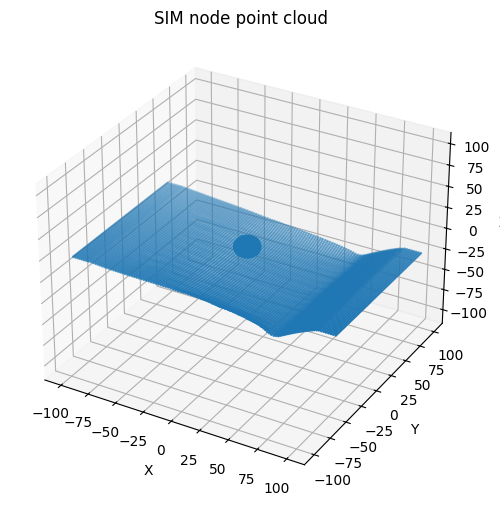

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("*") or s.startswith("$"):
                continue
            parts = s.split()
            if len(parts) < 4:
                continue
            nid = int(parts[0])
            x = float(parts[1]); y = float(parts[2]); z = float(parts[3])
            ids.append(nid)
            coords.append([x, y, z])
    return np.array(ids, dtype=int), np.array(coords, dtype=float)

sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")

print("SIM nodes:", sim_coords.shape[0])
print("mins:", sim_coords.min(axis=0))
print("maxs:", sim_coords.max(axis=0))
print("first 5 ids:", sim_ids[:5])
print("first 5 coords:\n", sim_coords[:5])

# Downsample for speed if huge
MAX_PLOT = 200000
if sim_coords.shape[0] > MAX_PLOT:
    idx = np.linspace(0, sim_coords.shape[0] - 1, MAX_PLOT).astype(int)
    plot_coords = sim_coords[idx]
    print(f"Downsampled to {plot_coords.shape[0]} points for plotting.")
else:
    plot_coords = sim_coords

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(plot_coords[:, 0], plot_coords[:, 1], plot_coords[:, 2], s=1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("SIM node point cloud")

# Approx equal axis scaling
mins = plot_coords.min(axis=0)
maxs = plot_coords.max(axis=0)
cent = 0.5 * (mins + maxs)
span = (maxs - mins).max()
ax.set_xlim(cent[0] - 0.5 * span, cent[0] + 0.5 * span)
ax.set_ylim(cent[1] - 0.5 * span, cent[1] + 0.5 * span)
ax.set_zlim(cent[2] - 0.5 * span, cent[2] + 0.5 * span)

plt.show()


In [5]:
!pip install pyvista

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### General function to plot the mesh

In [6]:
import os
os.environ["PYVISTA_OFF_SCREEN"] = "true"

import numpy as np
import pyvista as pv

def plot_shell_field(coords, conn, ids, vals,
                     field_name="field",
                     unique_value_per_node=True,
                     show_edges=False,
                     point_size=3,
                     screenshot_path="plot.png"):
    """
    Off-screen PyVista plotter that saves a PNG instead of opening a window.
    Works even when on-screen OpenGL fails.
    """
    coords = np.asarray(coords, float)
    ids = np.asarray(ids, int)
    conn = np.asarray(conn, int)

    id_to_idx = {nid: i for i, nid in enumerate(ids)}

    nelems, nen = conn.shape
    conn_idx = np.empty_like(conn, dtype=int)
    for e in range(nelems):
        conn_idx[e, :] = [id_to_idx[nid] for nid in conn[e, :]]

    cells = np.hstack((np.full((nelems, 1), nen, np.int64), conn_idx.astype(np.int64))).ravel()
    celltypes = np.full(nelems, pv.CellType.QUAD, dtype=np.uint8)

    grid = pv.UnstructuredGrid(cells, celltypes, coords)

    if unique_value_per_node:
        vals = np.asarray(vals)
        if vals.ndim == 2 and vals.shape[1] == 1:
            vals = vals[:, 0]
        if vals.shape[0] != coords.shape[0]:
            raise ValueError(f"vals must be length Nnodes={coords.shape[0]} when unique_value_per_node=True.")
        grid.point_data[field_name] = vals.astype(float)
        scalars = field_name
    else:
        vals = np.asarray(vals, float)
        if vals.shape != (nelems, nen):
            raise ValueError(f"vals must be shape (Ne,4)=({nelems},{nen}) when unique_value_per_node=False.")
        grid.cell_data[field_name] = vals.mean(axis=1)
        scalars = field_name

    # Off-screen plotter
    p = pv.Plotter(off_screen=True, window_size=(1400, 900))
    p.add_mesh(grid, scalars=scalars, show_edges=show_edges, point_size=point_size)
    p.add_axes()
    p.show_bounds(grid='front', location='outer', all_edges=True)

    p.show(screenshot=screenshot_path)  # saves PNG
    print(f"Saved screenshot to: {screenshot_path}")


### Step 3: Computed sim SDV interpolated at exp nodal points

first task: we need to have the transformed sim coords as follows: 

1) they can be translated along 3 dim 
2) they can be scaled along 3 dim 
3) they can be rotated along 3 axis in total 9 unknowns. 

We need to find these 9 unknown such that the eucleadean norms between sim and exp coords are minimized. The number of NPs are different so finding closest NP of exp to sim is needed. If the geometry is symmatric like a rectangle or circle then this minimization does not have unique solution, so not only the eucleudean distance needs to be minimized but also the magnitude of the 9 unknowns as well.

However, scaling optimization would make the algorithm to cheat by squeezing the the sim mesh to be close to one single exp nodal point, so we would scaled it analytically using (max -min) of each dim between sim and exp

### Purely analytic strategy: only scaling and translating to match the max and min of exp

In [7]:
import numpy as np

def analytic_align_sim_to_exp(sim_coords, exp_coords):
    """
    Analytic alignment:
    1) Per-axis scaling from bbox ranges (sim -> exp)
    2) Per-axis translation so max(sim_scaled) = max(exp)

    sim_coords : (Ns, 3)
    exp_coords : (Ne, 3)

    Returns
    -------
    sim_coords_transformed : (Ns, 3)
        Scaled + translated sim coordinates.
    scale : (3,)
        Per-axis scales [sx, sy, sz].
    translation : (3,)
        Per-axis translations [tx, ty, tz] applied *after* scaling.
    """

    sim_coords = np.asarray(sim_coords, dtype=float)
    exp_coords = np.asarray(exp_coords, dtype=float)

    # --- 1) Compute per-axis scales from bounding box ranges ---
    sim_min = sim_coords.min(axis=0)
    sim_max = sim_coords.max(axis=0)
    exp_min = exp_coords.min(axis=0)
    exp_max = exp_coords.max(axis=0)

    sim_range = sim_max - sim_min
    exp_range = exp_max - exp_min

    scale = np.ones(3, dtype=float)
    for i in range(3):
        if sim_range[i] > 0.0:
            scale[i] = exp_range[i] / sim_range[i]
        else:
            scale[i] = 1.0  # avoid division by zero if perfectly flat

    # scale sim coords
    sim_scaled = sim_coords * scale  # broadcast along rows

    # --- 2) Compute translation so that max(sim_scaled) = max(exp) per axis ---
    sim_scaled_max = sim_scaled.max(axis=0)
    translation = exp_max - sim_scaled_max

    # apply translation
    sim_coords_transformed = sim_scaled + translation

    return sim_coords_transformed, scale, translation

sim_coords_transformed, s_vec, t_vec = analytic_align_sim_to_exp(sim_coords_sheet, exp_coords)

print("scale [sx, sy, sz]     =", s_vec)
print("translation [tx,ty,tz] =", t_vec)

import numpy as np

# Sim (transformed) bounds
sim_min = sim_coords_transformed.min(axis=0)
sim_max = sim_coords_transformed.max(axis=0)

# Exp bounds
exp_min = exp_coords.min(axis=0)
exp_max = exp_coords.max(axis=0)

print()
print("Transformed SIM bounds:")
print(f"  x: min = {sim_min[0]: .6f}, max = {sim_max[0]: .6f}")
print(f"  y: min = {sim_min[1]: .6f}, max = {sim_max[1]: .6f}")
print(f"  z: min = {sim_min[2]: .6f}, max = {sim_max[2]: .6f}")

print("\nEXP bounds:")
print(f"  x: min = {exp_min[0]: .6f}, max = {exp_max[0]: .6f}")
print(f"  y: min = {exp_min[1]: .6f}, max = {exp_max[1]: .6f}")
print(f"  z: min = {exp_min[2]: .6f}, max = {exp_max[2]: .6f}")

# Optional: show the differences in bounds
print("\nDifferences (SIM_transformed - EXP):")
print(f"  x: Δmin = {sim_min[0] - exp_min[0]: .6f}, Δmax = {sim_max[0] - exp_max[0]: .6f}")
print(f"  y: Δmin = {sim_min[1] - exp_min[1]: .6f}, Δmax = {sim_max[1] - exp_max[1]: .6f}")
print(f"  z: Δmin = {sim_min[2] - exp_min[2]: .6f}, Δmax = {sim_max[2] - exp_max[2]: .6f}")




scale [sx, sy, sz]     = [0.867215   1.0070178  1.19518891]
translation [tx,ty,tz] = [-1.14450000e-05 -1.52600000e-05 -3.11556717e-02]

Transformed SIM bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

EXP bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

Differences (SIM_transformed - EXP):
  x: Δmin =  0.000000, Δmax =  0.000000
  y: Δmin =  0.000000, Δmax =  0.000000
  z: Δmin =  0.000000, Δmax =  0.000000


### Plot the sim mesh at the new transformed coords

In [ ]:
import numpy as np

def build_averaged_values_at_NPs(node_ids, elem_conn, elem_corner_vals):
    """
    Convert element-corner values (defined per element at its nodes) into a single
    averaged nodal value per node ID.

    Averaging is weighted purely by "how many elements share that node":
      nodal_value(n) = sum_over_incident_elements( value_at_that_element_corner ) / count_incident_elements

    Parameters
    ----------
    node_ids : (Nn,) int
        Global node IDs you want values for (e.g., sim_ids_sheet).
    elem_conn : (Ne, nen) int
        Element connectivity in NODE IDS (e.g., sim_conn_sheet). nen=4 for quads.
    elem_corner_vals : (Ne, nen) float
        Values at each element corner node in the same order as elem_conn
        (e.g., sim_thick_corner_sheet).

    Returns
    -------
    nodal_vals : (Nn,) float
        Averaged value at each node in `node_ids` order.
        Nodes not referenced by elem_conn will be NaN.
    counts : (Nn,) int
        Number of element-corner contributions accumulated for each node.
        (This is the divisor used in the average.)
    """
    node_ids = np.asarray(node_ids, dtype=int)
    elem_conn = np.asarray(elem_conn, dtype=int)
    elem_corner_vals = np.asarray(elem_corner_vals, dtype=float)

    if elem_conn.shape != elem_corner_vals.shape:
        raise ValueError(f"elem_conn shape {elem_conn.shape} must match elem_corner_vals shape {elem_corner_vals.shape}")

    id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

    sums = np.zeros(node_ids.shape[0], dtype=float)
    counts = np.zeros(node_ids.shape[0], dtype=int)

    Ne, nen = elem_conn.shape
    for e in range(Ne):
        for a in range(nen):
            nid = int(elem_conn[e, a])
            idx = id_to_idx.get(nid, None)
            if idx is None:
                continue
            sums[idx] += float(elem_corner_vals[e, a])
            counts[idx] += 1

    nodal_vals = np.full(node_ids.shape[0], np.nan, dtype=float)
    mask = counts > 0
    nodal_vals[mask] = sums[mask] / counts[mask]

    return nodal_vals

sim_thick_corner_averaged_sheet = build_averaged_values_at_NPs(
    sim_ids_sheet,
    sim_conn_sheet,
    sim_thick_corner_sheet
)


: 

In [ ]:
plot_shell_field(sim_coords_transformed, sim_conn_sheet, sim_ids, sim_thick_corner_averaged_sheet)

ERROR:root:failed to get wglChoosePixelFormatARB
ERROR:root:failed to get valid pixel format.


projected plane if XY then we discard Z dim YZ discard X dim XZ discard Y dim (this is useful for later code where the model shows most variation along a specific plane) 

then the algorithm in 2D works like this for each node of exp in 2d, find the element of sim in 2d that contains that node. if lies on edge or corner of sims then choose any random element (this is becaus shape function will make them behave correctly no matter what elements it belongs to. 

then use bilinear shape funcion to compute that node of exp from sim 4 nodal points. hardest code is only to find element ID of sim that the exp node lies in. in worst case if doesnt lie in any elements then find closest NP of sim and give it value of that closest sim

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# ------------------------------------------------------------
# Helper: build 0-based connectivity from LS-DYNA node IDs
# ------------------------------------------------------------
def _build_conn_idx(sim_conn, sim_ids):
    """
    Convert LS-DYNA node IDs in sim_conn to 0-based indices
    into sim_coords / sim_sig_vals.
    """
    sim_conn = np.asarray(sim_conn, dtype=int)
    id_to_idx = {nid: i for i, nid in enumerate(sim_ids)}
    nelems, nen = sim_conn.shape
    conn_idx = np.zeros_like(sim_conn, dtype=int)
    for e in range(nelems):
        conn_idx[e, :] = [id_to_idx[nid] for nid in sim_conn[e, :]]
    return conn_idx


# ------------------------------------------------------------
# Helper: Newton solve for (ξ,η) in a bilinear quad
# ------------------------------------------------------------
def _local_coords_bilinear(xy_nodes, p, tol=1e-8, max_iter=15):
    """
    Solve for parent coords (ξ,η) such that
        x(ξ,η) = sum N_i(ξ,η) x_i = p[0]
        y(ξ,η) = sum N_i(ξ,η) y_i = p[1]
    using Newton iteration.

    xy_nodes: (4,2) array of (x_i, y_i) nodal coords
    p       : (2,) target point (x, y)
    Returns:
        xi, eta, success (bool), inside (bool)
    """
    x_i = xy_nodes[:, 0]
    y_i = xy_nodes[:, 1]
    x_target, y_target = p

    xi = 0.0
    eta = 0.0

    for _ in range(max_iter):
        # Shape functions
        N1 = 0.25 * (1 - xi) * (1 - eta)
        N2 = 0.25 * (1 + xi) * (1 - eta)
        N3 = 0.25 * (1 + xi) * (1 + eta)
        N4 = 0.25 * (1 - xi) * (1 + eta)
        N = np.array([N1, N2, N3, N4])

        # Derivatives w.r.t. xi, eta
        dN_dxi = 0.25 * np.array([
            -(1 - eta),   # dN1/dxi
             (1 - eta),   # dN2/dxi
             (1 + eta),   # dN3/dxi
            -(1 + eta),   # dN4/dxi
        ])
        dN_deta = 0.25 * np.array([
            -(1 - xi),    # dN1/deta
            -(1 + xi),    # dN2/deta
             (1 + xi),    # dN3/deta
             (1 - xi),    # dN4/deta
        ])

        # Current mapped point
        x_cur = np.dot(N, x_i)
        y_cur = np.dot(N, y_i)

        # Residual
        rx = x_cur - x_target
        ry = y_cur - y_target
        r = np.array([rx, ry])

        if np.linalg.norm(r) < tol:
            # converged; check inside in a separate step
            inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
            return xi, eta, True, inside

        # Jacobian J = [dx/dxi  dx/deta; dy/dxi  dy/deta]
        dx_dxi = np.dot(dN_dxi, x_i)
        dx_deta = np.dot(dN_deta, x_i)
        dy_dxi = np.dot(dN_dxi, y_i)
        dy_deta = np.dot(dN_deta, y_i)

        J = np.array([[dx_dxi, dx_deta],
                      [dy_dxi, dy_deta]])

        detJ = np.linalg.det(J)
        if abs(detJ) < 1e-14:
            # element is degenerate or extremely distorted here
            return xi, eta, False, False

        # Newton update
        delta = np.linalg.solve(J, -r)
        xi  += delta[0]
        eta += delta[1]

    # Not converged
    inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
    return xi, eta, False, inside


# ------------------------------------------------------------
# Main interpolation function (as you specified)
# ------------------------------------------------------------
def interpolate_sdv_2d_plane(
    sim_coords_transformed,
    exp_coords,
    sim_sig_vals,
    projected_plane="XY",
    k_elem_candidates=16
):
    """
    Interpolate SDV (e.g. von Mises) from SIM shell mesh to EXP nodes
    using 2D bilinear shape functions in a chosen projection plane.

    Parameters
    ----------
    sim_coords_transformed : (Ns,3)
        Transformed SIM nodal coordinates (after scaling/translation/etc.).
    exp_coords : (Ne,3)
        EXP nodal coordinates.
    sim_sig_vals : (Ns,)
        Scalar values at SIM nodes (aligned with sim_ids & sim_coords_transformed).
    projected_plane : {"XY", "YZ", "XZ"}
        Plane to project onto:
        - "XY": use (x, y), discard z
        - "YZ": use (y, z), discard x
        - "XZ": use (x, z), discard y
    k_elem_candidates : int
        How many nearest elements (by centroid) to try for each EXP node.

    Returns
    -------
    exp_sig_vals : (Ne,)
        Interpolated scalar at EXP nodes.
    """

    # --- choose projection indices ---
    plane = projected_plane.upper()
    if plane == "XY":
        ia, ib = 0, 1
    elif plane == "YZ":
        ia, ib = 1, 2
    elif plane == "XZ":
        ia, ib = 0, 2
    else:
        raise ValueError(f"Unsupported projected_plane: {projected_plane}")

    # --- project to 2D ---
    sim_xy = np.column_stack((sim_coords_transformed[:, ia],
                              sim_coords_transformed[:, ib]))
    exp_xy = np.column_stack((exp_coords[:, ia],
                              exp_coords[:, ib]))

    # --- build 0-based connectivity (global sim_conn & sim_ids) ---
    global sim_conn, sim_ids  # assumes they exist in your environment
    conn_idx = _build_conn_idx(sim_conn, sim_ids)  # (Ne,4)

    nelems = conn_idx.shape[0]

    # --- precompute element centroids in 2D ---
    elem_centroids = np.zeros((nelems, 2), dtype=float)
    for e in range(nelems):
        elem_xy = sim_xy[conn_idx[e, :]]
        elem_centroids[e, :] = elem_xy.mean(axis=0)

    # KDTree on element centroids for candidate search
    tree_elems = cKDTree(elem_centroids)

    # KDTree on SIM nodes for fallback nearest-node interpolation
    tree_nodes = cKDTree(sim_xy)

    exp_sig_vals = np.zeros(exp_coords.shape[0], dtype=float)

    for j, p in enumerate(exp_xy):
        # 1) find k nearest element centroids
        k = min(k_elem_candidates, nelems)
        d_e, idx_e = tree_elems.query(p, k=k)

        # ensure idx_e iterable
        if k == 1:
            idx_e = np.array([idx_e])

        found = False

        # 2) try each candidate element: solve (ξ,η), check inside, interpolate
        for e in idx_e:
            node_ids = conn_idx[e, :]   # 4 node indices (0-based)
            xy_nodes = sim_xy[node_ids] # (4,2)

            xi, eta, converged, inside = _local_coords_bilinear(xy_nodes, p)
            if not inside:
                continue  # try next candidate

            # use bilinear shape functions at (xi, eta)
            N1 = 0.25 * (1 - xi) * (1 - eta)
            N2 = 0.25 * (1 + xi) * (1 - eta)
            N3 = 0.25 * (1 + xi) * (1 + eta)
            N4 = 0.25 * (1 - xi) * (1 + eta)
            N = np.array([N1, N2, N3, N4])

            vals_elem = sim_sig_vals[node_ids]  # scalar at 4 SIM nodes
            exp_sig_vals[j] = float(N @ vals_elem)
            found = True
            break  # no need to check other elements

        if not found:
            # 3) Fallback: nearest SIM node in 2D, copy its value
            _, idx_node = tree_nodes.query(p, k=1)
            exp_sig_vals[j] = float(sim_sig_vals[idx_node])

    return exp_sig_vals

exp_sig_vals = interpolate_sdv_2d_plane(
    sim_coords_transformed,
    exp_coords,
    sim_sig_vals,
    projected_plane="XY",
)


C:\Users\nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


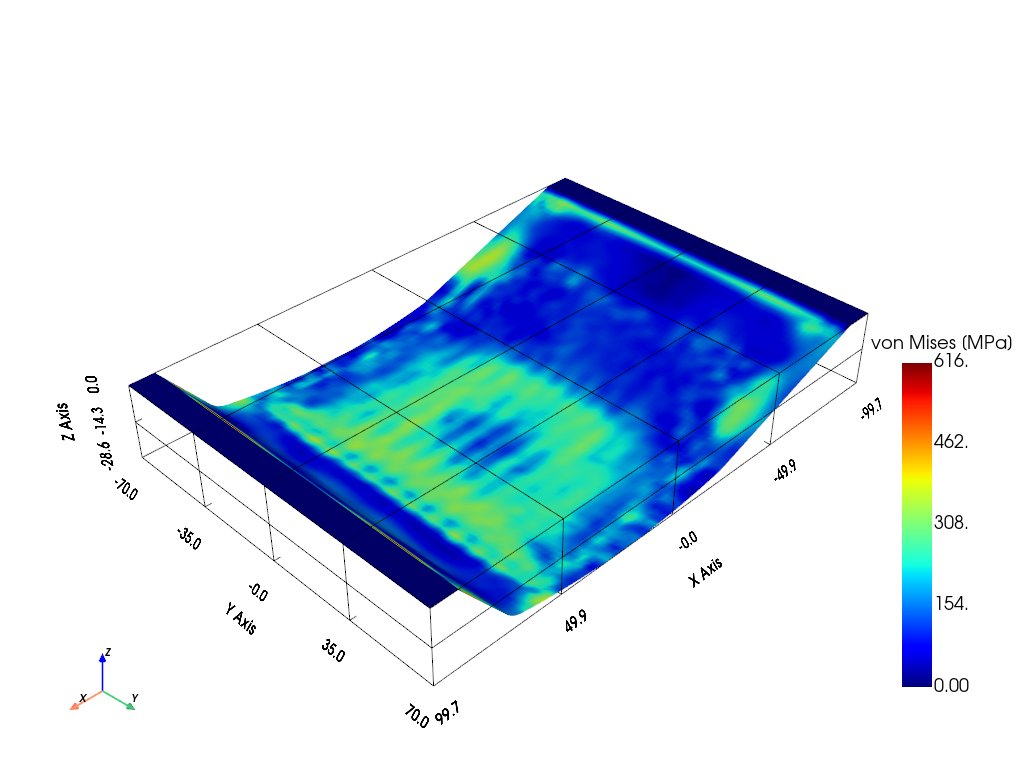

In [ ]:
plot_shell_field(exp_coords, exp_conn, exp_ids, exp_sig_vals)